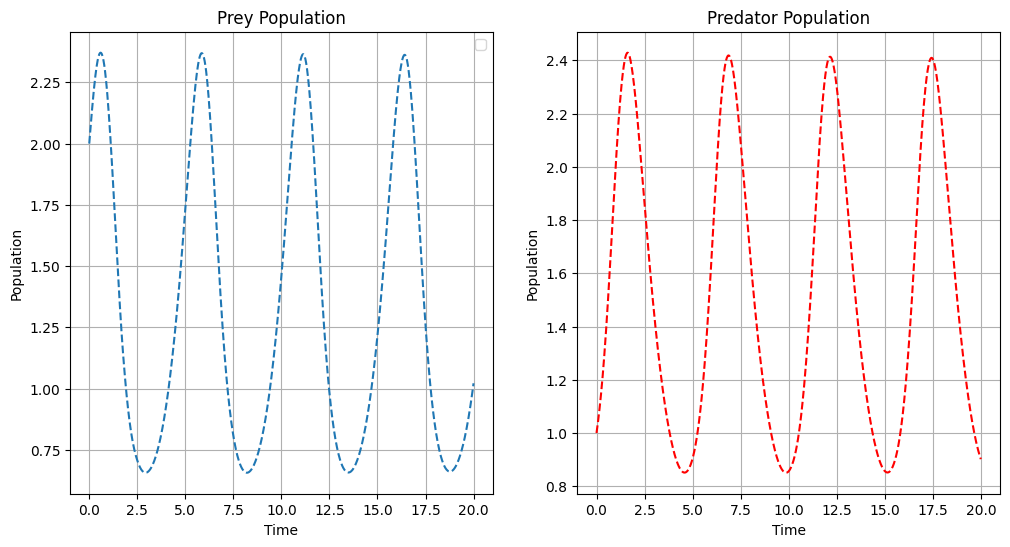

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf

# Параметры системы Лотки-Вольтерры
alpha = 1.5
beta = 1
delta = 0.75
gamma = 1

# Начальные условия
x0 = 2
y0 = 1

# Временной интервал
t_start = 0
t_end = 20
num_points = 1000
t_train = np.linspace(t_start, t_end, num_points)

# Функция для системы уравнений Лотки-Вольтерры
def lotka_volterra(t, z):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Решение с помощью метода Рунге-Кутты
sol = solve_ivp(lotka_volterra, [t_start, t_end], [x0, y0], t_eval=t_train)
x_true, y_true = sol.y

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t_train, x_true, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Prey Population')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_train, y_true, linestyle='--', c='r')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator Population')
plt.grid()

plt.show()

Epoch 0, Loss: 0.10398150235414505
Epoch 100, Loss: 1.2339935892669018e-05
Epoch 200, Loss: 3.0931723813409917e-06
Epoch 300, Loss: 9.278452353100874e-07
Epoch 400, Loss: 4.071147827744426e-07
Epoch 500, Loss: 2.2873246052768081e-07
Epoch 600, Loss: 1.473163848686454e-07
Epoch 700, Loss: 1.078458922165737e-07
Epoch 800, Loss: 8.739330326079653e-08
Epoch 900, Loss: 7.496957010744154e-08


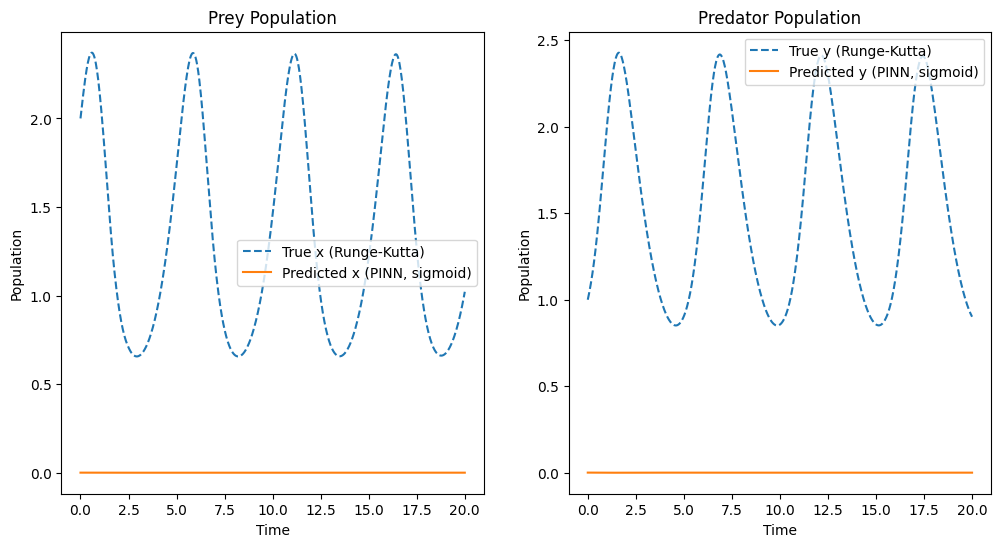

Epoch 0, Loss: 0.5000500082969666
Epoch 100, Loss: 0.00012972779222764075
Epoch 200, Loss: 5.364354728953913e-05
Epoch 300, Loss: 2.321242391190026e-05
Epoch 400, Loss: 1.1422983334341552e-05
Epoch 500, Loss: 6.242914423637558e-06
Epoch 600, Loss: 3.533589506332646e-06
Epoch 700, Loss: 2.0498687263170723e-06
Epoch 800, Loss: 1.2430778042471502e-06
Epoch 900, Loss: 8.057981517595181e-07


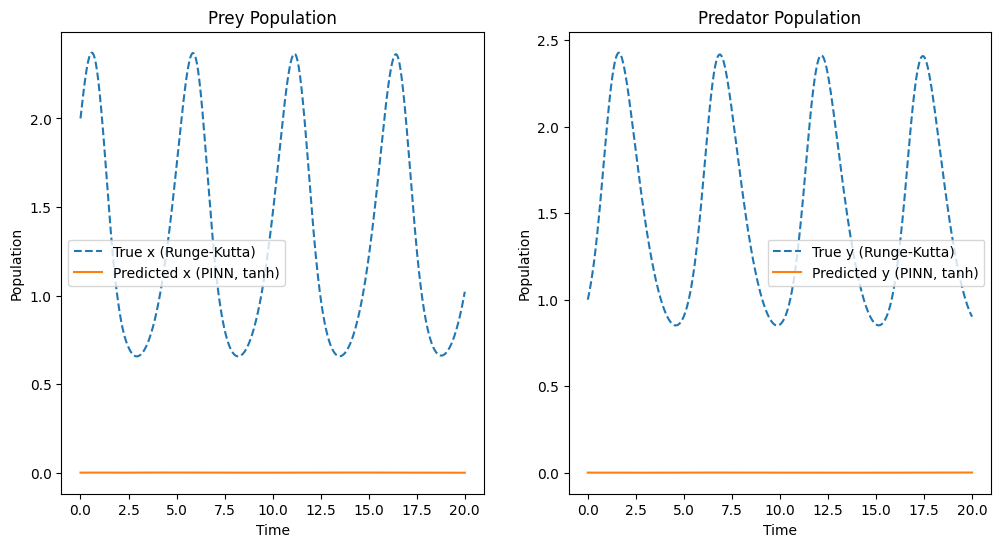

Epoch 0, Loss: 2.794668674468994
Epoch 100, Loss: 0.00036178348818793893
Epoch 200, Loss: 0.0001602509873919189
Epoch 300, Loss: 0.00014629644283559173
Epoch 400, Loss: 0.0001331610546912998
Epoch 500, Loss: 0.00012075898121111095
Epoch 600, Loss: 0.00010905970702879131
Epoch 700, Loss: 9.803625289350748e-05
Epoch 800, Loss: 8.76832491485402e-05
Epoch 900, Loss: 7.798826845828444e-05


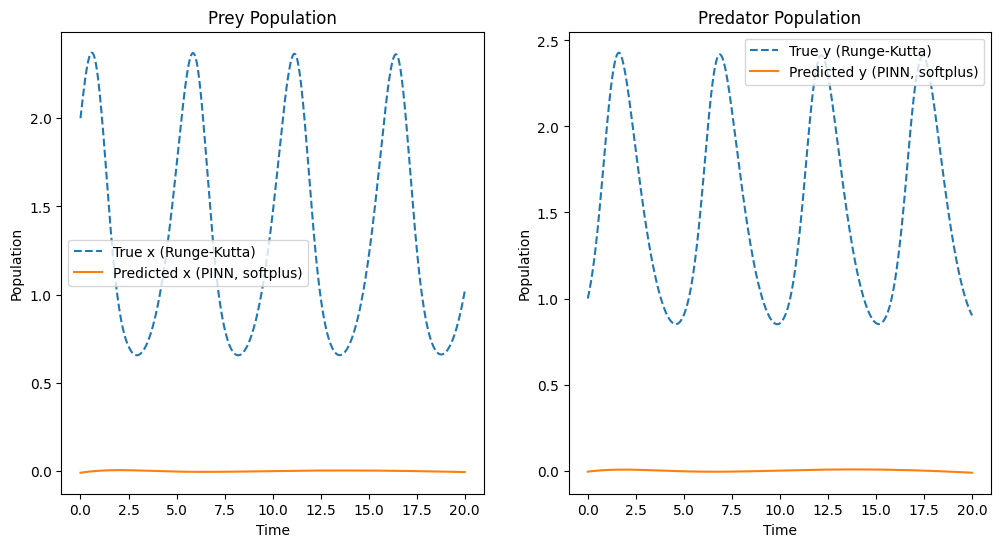

Epoch 0, Loss: 1.2344229221343994
Epoch 100, Loss: 0.00021531005040742457
Epoch 200, Loss: 1.843638347054366e-05
Epoch 300, Loss: 1.1161840120621491e-05
Epoch 400, Loss: 7.829949026927352e-06
Epoch 500, Loss: 5.916673671890749e-06
Epoch 600, Loss: 4.733977675641654e-06
Epoch 700, Loss: 3.96065843233373e-06
Epoch 800, Loss: 3.4273859910172177e-06
Epoch 900, Loss: 3.039880994037958e-06


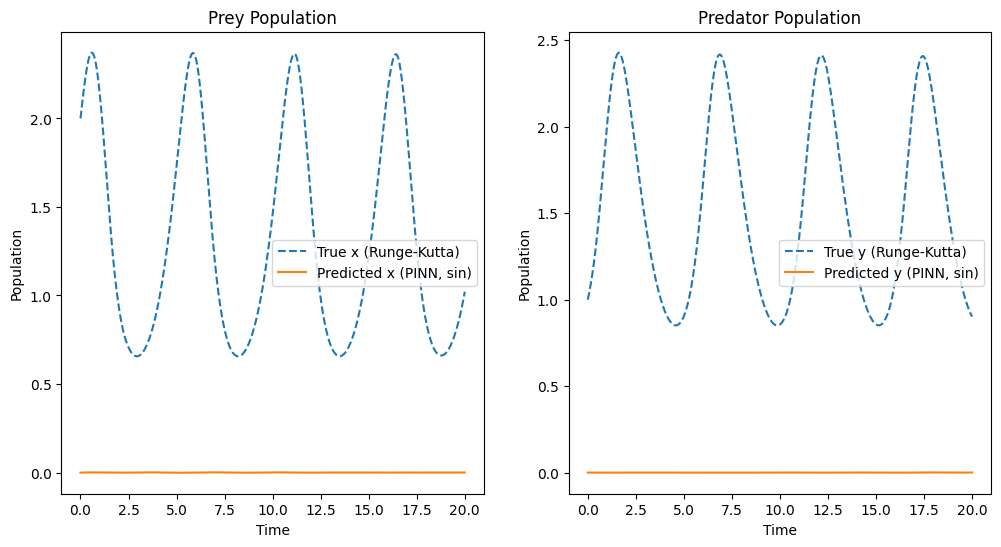

In [15]:
# попытки обучения
# Нейронная сеть
class PINN(tf.keras.Model):
    def __init__(self, activation='tanh'):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation=activation)
        self.dense2 = tf.keras.layers.Dense(20, activation=activation)
        self.dense3 = tf.keras.layers.Dense(2)

    def call(self, t):
        t = tf.reshape(t, [-1, 1])
        hidden = self.dense1(t)
        hidden = self.dense2(hidden)
        output = self.dense3(hidden)
        return output

# Функция потерь
def loss_fn(model, t):
    t = tf.convert_to_tensor(t, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        x_pred, y_pred = tf.split(model(t), 2, axis=1)
        dxdt_pred = tape.gradient(x_pred, t)
        dydt_pred = tape.gradient(y_pred, t)
    dxdt_true = alpha * x_pred - beta * x_pred * y_pred
    dydt_true = delta * x_pred * y_pred - gamma * y_pred
    loss = tf.reduce_mean(tf.square(dxdt_pred - dxdt_true)) + tf.reduce_mean(tf.square(dydt_pred - dydt_true))
    return loss

# Обучение модели
def train_model(model, t_train, epochs=1000, lr=0.01):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, t_train)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Функции активации для исследования
activations = ['sigmoid', 'tanh', 'softplus', tf.sin]

# Сравнение результатов
for activation in activations:
    model = PINN(activation=activation)
    train_model(model, t_train)
    x_pred, y_pred = model(t_train).numpy().T

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(t_train, x_true, label='True x (Runge-Kutta)', linestyle='--')
    plt.plot(t_train, x_pred, label=f'Predicted x (PINN, {activation.__name__ if hasattr(activation, "__name__") else activation})')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Prey Population')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t_train, y_true, label='True y (Runge-Kutta)', linestyle='--')
    plt.plot(t_train, y_pred, label=f'Predicted y (PINN, {activation.__name__ if hasattr(activation, "__name__") else activation})')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Predator Population')
    plt.legend()

    plt.show()